In [1]:
#import the module and relevant packages.
#Here we'll be doing RPE on a gate set with pi/2 X and Y rotations, along with preparation in |0>
#and "positive" measurement in |1>.

import pygsti as gst
import pygsti.construction.std1Q_XY as Std1Q_XY
from pygsti.tools.rpeconfig_GxPi2_GyPi2_UpDn import rpeconfig_GxPi2_GyPi2_UpDn
from pygsti.tools import rpe as RPE
from pygsti.construction import rpeconstruction as RPEConstr

import numpy as np
import time
import pickle

Fully specified RPE configuration.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
#Load the rpeinstance file which will be used to define a collection of relevant parameters,
#including what RPE gate sequences should be used, and what inversion functions should be used.
rpeconfig_inst = rpeconfig_GxPi2_GyPi2_UpDn

In [4]:
#Declare more relevant parameters, here mostly for GST.

gs_target = Std1Q_XY.gs_target
maxLengths_1024 = [0,1,2,4,8,16,32,64,128,256,512,1024]
fiducials = Std1Q_XY.fiducials
#measFiducials = Std1Q_XY.fiducials
germs = gst.construction.gatestring_list([('Gy',),
 ('Gy','Gy','Gy','Gx',),
 ('Gy','Gx','Gy','Gx','Gx','Gx',),
 ('Gy','Gx','Gy','Gy','Gx','Gx',),
 ('Gy','Gy','Gy','Gx','Gy','Gx',),
 ('Gx',),
 ('Gx','Gy',),
 ('Gx','Gx','Gy','Gx','Gy','Gy',)])
stringListsGST = gst.construction.make_lsgst_lists(gs_target.gates.keys(), fiducials, fiducials, germs, maxLengths_1024)

stringListsRPE = RPEConstr.make_rpe_angle_string_list_dict(10,rpeconfig_inst)

In [5]:
#Make some dictionary containers to contain our GST gate set estimates, our GST and RPE angle estimates, and 
#the number of unique experimental sequences used for GST and RPE as a function of experiment generation.
gsEstD = {}

expAngleD = {}

numStrsD = {}

In [6]:
#Make empty lists to be populated by our error bars (as a function of experiment generation) for each angle.

alphaGSTErrorBarList = []
epsilonGSTErrorBarList = []
thetaGSTErrorBarList = []

In [7]:
#Record the number of unique experimental sequences used for GST and RPE as a function of experiment generation.
numStrsD['RPE'] = [6*i for i in np.arange(1,12)]
numStrsD['GST'] = [len(stringList) for stringList in stringListsGST][1:]

In [8]:
#Load the experimental data.

DSGST = gst.io.load_dataset('tutorial_files/2016_02_22-GST-BB1-XYXY-1024-002-029_condensed.txt',cache=True)
DSRPE = gst.io.load_dataset('tutorial_files/2016_02_22-RPE-BB1-XYXY-1024-002-029_condensed.txt',cache=True)

Loading from cache file:  tutorial_files/2016_02_22-GST-BB1-XYXY-1024-002-029_condensed.txt.cache
Loading from cache file:  tutorial_files/2016_02_22-RPE-BB1-XYXY-1024-002-029_condensed.txt.cache


In [9]:
#Run GST analysis; record the gate set estimates, and extract the corresponding angles.

method = 'GST'

baseKey =  ('Exp. N=370',)

DSTemp = DSGST

resultsGST = gst.do_long_sequence_gst(DSTemp,gs_target,fiducials,fiducials,germs,maxLengths_1024,constrainToTP=True,advancedOptions={'verbosity':0})

gsEstD[baseKey] = resultsGST.gatesets

for kInd, k in enumerate(maxLengths_1024):
    alphaKey = ('alpha','GST')+baseKey+('k',k)
    epsilonKey = ('epsilon','GST')+baseKey+('k',k)
    thetaKey = ('theta','GST')+baseKey+('k',k)
    expAngleD[alphaKey] = []
    expAngleD[epsilonKey] = []
    expAngleD[thetaKey] = []
    gsEstKey = baseKey
    gs = gst.optimize_gauge(gsEstD[baseKey]['iteration estimates'][kInd],'target',targetGateset=gs_target,constrainToTP=True,spamWeight=1e-4)
    expAngleD[alphaKey] += [RPE.extract_alpha(gs,rpeconfig_inst)]
    expAngleD[epsilonKey] += [RPE.extract_epsilon(gs,rpeconfig_inst)]
    expAngleD[thetaKey] += [RPE.extract_theta(gs,rpeconfig_inst)]

LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[ 4.24356766  1.44450787  1.38390969  1.33532798  0.07735167  0.04114918]

--- LGST ---

--- Gauge Optimization to TP (L-BFGS-B) ---
    5s           0.0000000918
    5s           0.0000000872
The resulting TP penalty is: 8.71986e-08
The gauge matrix found (B^-1) is:
[[  1.00007045e+00   4.82710558e-05   7.21042113e-05  -1.02617764e-05]
 [  1.25400944e-08   9.99999964e-01   1.57869887e-08  -2.12950356e-09]
 [ -3.00211868e-08   1.58937661e-08   9.99999969e-01   4.43252329e-09]
 [  2.72904644e-09  -3.68716571e-09   2.12890594e-09   9.99999997e-01]]

The gauge-corrected gates are:
rho0 =    0.7072   0.0204  -0.0010   0.6997


E0 =    0.6931   0.0542  -0.0265  -0.6885


Gx = 
   0.9999   0.0002        0        0
  -0.0156   0.9942  -0.0432  -0.0002
   0.0195  -0.0422   0.0179  -0.9992
  -0.0198   0.1103   1.0041  -0.0014


Gy = 
   0.9999        0  -0.0001        0
  -0.0048  -0.0225   0.0034   0.9901
   0.0148  -0.0118   0.9

In [10]:
#Redo the above analysis, but extract error bars at each generation.  This could certainly be 
#optimized to minimize redundancy, but the additional cost is not large at present in terms of runtime.

method = 'GST'

baseKey =  ('Exp. N=370',)

DSTemp = DSGST


for kInd, kMax in enumerate(maxLengths_1024[:-1]):
    resultsTempGST = gst.do_long_sequence_gst(DSTemp,gs_target,fiducials,fiducials,germs,[0]+[2**k for k in xrange(kInd+1)],constrainToTP=True,advancedOptions={'verbosity':0})
    resultsTempGST.confidence_level = 95
    alphaErrorBar = resultsTempGST.tables['bestGatesetRotnAxisTable']['Gx']['Angle']['errbar']
    epsilonErrorBar = resultsTempGST.tables['bestGatesetRotnAxisTable']['Gy']['Angle']['errbar']
    thetaErrorBar = resultsTempGST.tables['bestGatesetVsTargetAnglesTable']['Gy']['Angle between rotation axes']['errbar']
    alphaGSTErrorBarList.append(alphaErrorBar)
    epsilonGSTErrorBarList.append(epsilonErrorBar)
    thetaGSTErrorBarList.append(thetaErrorBar)

LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[ 4.24356766  1.44450787  1.38390969  1.33532798  0.07735167  0.04114918]

--- LGST ---

--- Gauge Optimization to TP (L-BFGS-B) ---
   35s           0.0000000918
   35s           0.0000000872
The resulting TP penalty is: 8.71986e-08
The gauge matrix found (B^-1) is:
[[  1.00007045e+00   4.82710558e-05   7.21042113e-05  -1.02617764e-05]
 [  1.25400944e-08   9.99999964e-01   1.57869887e-08  -2.12950356e-09]
 [ -3.00211868e-08   1.58937661e-08   9.99999969e-01   4.43252329e-09]
 [  2.72904644e-09  -3.68716571e-09   2.12890594e-09   9.99999997e-01]]

The gauge-corrected gates are:
rho0 =    0.7072   0.0204  -0.0010   0.6997


E0 =    0.6931   0.0542  -0.0265  -0.6885


Gx = 
   0.9999   0.0002        0        0
  -0.0156   0.9942  -0.0432  -0.0002
   0.0195  -0.0422   0.0179  -0.9992
  -0.0198   0.1103   1.0041  -0.0014


Gy = 
   0.9999        0  -0.0001        0
  -0.0048  -0.0225   0.0034   0.9901
   0.0148  -0.0118   0.9

In [11]:
#Run RPE analysis; record the corresponding angles.

method = 'RPE'

baseKey =  ('Exp. N=370',)

#startAll = time.time()
#seedCounter = 0
#gsEstKey =  ('deltaAlpha',deltaAlpha,'deltaEpsilon',deltaEpsilon,'Zrot',Zrot,'SPAMdepol',SPAMdepol,'N',N,'run',i)
#print "N, Run =", N, i
#startOne = time.time()
DSTemp = DSRPE

for kInd, k in enumerate(maxLengths_1024[1:]):    
    alphaKey = ('alpha','RPE')+baseKey+('k',k)
    epsilonKey = ('epsilon','RPE')+baseKey+('k',k)
    thetaKey = ('theta','RPE')+baseKey+('k',k)
    expAngleD[alphaKey] = []
    expAngleD[epsilonKey] = []
    expAngleD[thetaKey] = []

resultsTemp = RPE.analyze_rpe_data(DSTemp,gs_target,stringListsRPE,rpeconfig_inst)
for kInd, k in enumerate(maxLengths_1024[1:]):    
    alphaKey = ('alpha','RPE')+baseKey+('k',k)
    epsilonKey = ('epsilon','RPE')+baseKey+('k',k)
    thetaKey = ('theta','RPE')+baseKey+('k',k)

    expAngleD[alphaKey] += [resultsTemp['alphaHatList'][kInd]]
    expAngleD[epsilonKey] += [resultsTemp['epsilonHatList'][kInd]]
    expAngleD[thetaKey] += [resultsTemp['thetaHatList'][kInd]]

In [12]:
#Compute RPE bootstrapped data sets for error bars on RPE analysis.

boostrapRPEDSList = [gst.bootstrap.make_bootstrap_dataset(DSRPE,'nonparametric',seed=i) for i in xrange(100)]

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

In [13]:
#Analyze bootstrapped data sets with RPE.

startAll = time.time()
baseKey =  ('Exp. N=370',)

trials = 100

for kInd, k in enumerate(maxLengths_1024[1:]):    
    alphaKey = ('alpha','RPE-BS')+baseKey+('k',k)
    epsilonKey = ('epsilon','RPE-BS')+baseKey+('k',k)
    thetaKey = ('theta','RPE-BS')+baseKey+('k',k)
    expAngleD[alphaKey] = []
    expAngleD[epsilonKey] = []
    expAngleD[thetaKey] = []

for i in xrange(trials):
#        print "N, Run =", N, i
#        gsEstKey =  ('deltaAlpha',deltaAlpha,'deltaEpsilon',deltaEpsilon,'Zrot',Zrot,'SPAMdepol',SPAMdepol,'N',N,'run',i)
    DSTemp = boostrapRPEDSList[i].copy()
    resultsTemp = RPE.analyze_rpe_data(DSTemp,gs_target,stringListsRPE,rpeconfig_inst)
    for kInd, k in enumerate(maxLengths_1024[1:]):    
        alphaKey = ('alpha','RPE-BS')+baseKey+('k',k)
        epsilonKey = ('epsilon','RPE-BS')+baseKey+('k',k)
        thetaKey = ('theta','RPE-BS')+baseKey+('k',k)

        expAngleD[alphaKey] += [resultsTemp['alphaHatList'][kInd]]
        expAngleD[epsilonKey] += [resultsTemp['epsilonHatList'][kInd]]
        expAngleD[thetaKey] += [resultsTemp['thetaHatList'][kInd]]
    del DSTemp
    del resultsTemp
#        print endOne - startOne

In [14]:
#Compute RPE error bars (2*sigma ~= 95% error bars) from bootstrapped data sets.

trials = 100
method = 'RPE-BS'
baseKey =  ('Exp. N=370',)

alphaRPEErrorBarList = [2*np.std(expAngleD[('alpha',method)+baseKey+('k',k)]) for k in maxLengths_1024[1:]]
epsilonRPEErrorBarList = [2*np.std(expAngleD[('epsilon',method)+baseKey+('k',k)]) for k in maxLengths_1024[1:]]
thetaRPEErrorBarList = [2*np.std(expAngleD[('theta',method)+baseKey+('k',k)]) for k in maxLengths_1024[1:]]


In [15]:
#Print final GST and RPE angle estimates, with error bars
print "GST final estimates:"
print "pi/2 - alpha =",np.pi/2-expAngleD[('alpha', 'GST', 'Exp. N=370', 'k', 1024)][0]," +/-", alphaGSTErrorBarList[-1] 
print "pi/2 - epsilon =",np.pi/2-expAngleD[('epsilon', 'GST', 'Exp. N=370', 'k', 1024)][0]," +/-", epsilonGSTErrorBarList[-1]
print "theta =",expAngleD[('theta', 'GST', 'Exp. N=370', 'k', 1024)][0]," +/-", thetaGSTErrorBarList[-1]
print
print "RPE final estimates"
print "pi/2 - alpha =",np.pi/2-expAngleD[('alpha', 'RPE', 'Exp. N=370', 'k', 1024)][0]," +/-", alphaRPEErrorBarList[-1] 
print "pi/2 - epsilon =",np.pi/2-expAngleD[('epsilon', 'RPE', 'Exp. N=370', 'k', 1024)][0]," +/-", epsilonRPEErrorBarList[-1]
print "theta =",expAngleD[('theta', 'RPE', 'Exp. N=370', 'k', 1024)][0]," +/-", thetaRPEErrorBarList[-1]


GST final estimates:
pi/2 - alpha = -6.39056800347e-05  +/- 1.55725011739e-05
pi/2 - epsilon = -2.7346733537e-05  +/- 1.1255428288e-05
theta = 6.28708228231e-05  +/- 0.000153154983215

RPE final estimates
pi/2 - alpha = -0.00016631698275  +/- 0.000111720649309
pi/2 - epsilon = -0.000126662633937  +/- 0.000114336714167
theta = 0.000209149198603  +/- 5.88728620371e-05


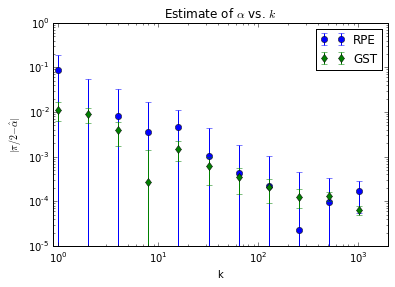

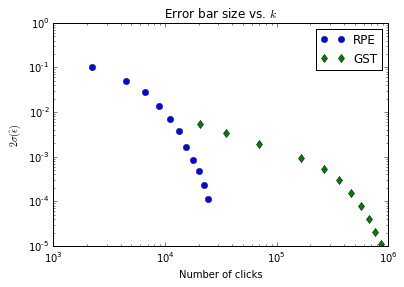

In [16]:
#Now for a fun couple of plots!  We'll plot pi/2 - estimate of alpha vs sequence length k for GST and RPE, and also
#GST and RPE error bars on alpha as a function of k.  We could do similar plots for epsilon and theta.

plt.errorbar(maxLengths_1024[1:], [np.abs(np.pi/2-expAngleD[('alpha', 'RPE', 'Exp. N=370', 'k', k)][0]) for k in maxLengths_1024[1:]],yerr=alphaRPEErrorBarList,marker='o',linestyle='',label='RPE')
plt.errorbar(maxLengths_1024[1:], [np.abs(np.pi/2-expAngleD[('alpha', 'GST', 'Exp. N=370', 'k', k)][0]) for k in maxLengths_1024[1:]],yerr=alphaGSTErrorBarList,marker='d',linestyle='',label='GST')

plt.xscale('log')
plt.yscale('log')
plt.xlim(9e-1,2e3)
plt.xlabel('k')
plt.ylabel(r'$|\pi/2-\hat\alpha|$')

plt.legend()

plt.title(r'Estimate of $\alpha$ vs. $k$')

plt.show()

plt.loglog(370*np.array(numStrsD['RPE']), epsilonRPEErrorBarList,marker='o',linestyle='',label='RPE')
plt.loglog(370*np.array(numStrsD['GST']), epsilonGSTErrorBarList,marker='d',linestyle='',label='GST')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of clicks')
plt.ylabel(r'$2\sigma(\hat\epsilon)$')

plt.legend()

plt.title(r'Error bar size vs. $k$')

plt.show()